In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [6]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/fire"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/fire/03_model_weights/resnet"
MODEL_NAME = "20240515_1510"

In [7]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [9]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]


In [10]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")

DIR_CAL_UNET_EMB = os.path.join(BASE_DIR, "04_predictions/cal/embeddings",)
DIR_TEST_UNET_EMB = DIR_CAL_UNET_EMB.replace("cal", "test")



In [11]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [13]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS
)


0it [00:00, ?it/s]

3432it [00:02, 1596.17it/s]


In [14]:
test_pred_probas, test_res_emb, test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS
)

6865it [00:04, 1594.97it/s]


In [15]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:05<00:00,  3.23it/s]


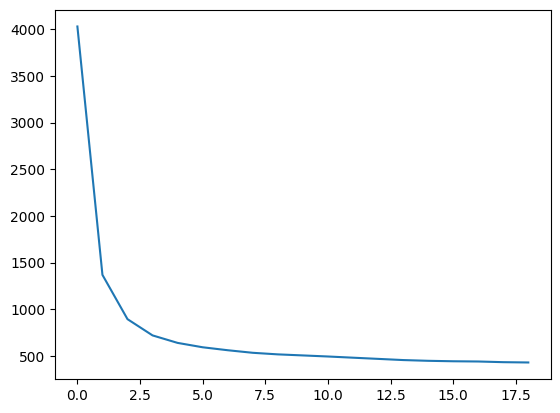

In [17]:
# create clustering with the embeddings and show the intra cluster variance according to the nb of clusters

from sklearn.cluster import KMeans

max_clusters = 20
intra_cluster_variance = np.zeros(max_clusters)
for n_clusters in tqdm(range(1, max_clusters)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cal_res_emb)
    intra_cluster_variance[n_clusters] = kmeans.inertia_

plt.plot(intra_cluster_variance[1:])



In [18]:
N_CLUSTERS = 5

kmeans_res = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(cal_res_emb)

cal_res_clusters_dist = kmeans_res.transform(cal_res_emb)
test_res_clusters_dist = kmeans_res.transform(test_res_emb)

# normalize the distances
cal_res_clusters_dist /= cal_res_clusters_dist.sum(axis=1)[:, None]
test_res_clusters_dist /= test_res_clusters_dist.sum(axis=1)[:, None]

In [19]:
ALPHA = .1
N = len(cal_labels)
REGULARIZATION = "ridge"

In [20]:
def grid_search_lambda(labels, pred_probas, embeddings, embedding_size):
    lambdas = [0, 0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.seed(42)
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = embeddings[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([embeddings[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, embedding_size),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, len(cal_labels), REGULARIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - (1 - ALPHA))) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

# Fit CRC

In [21]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [22]:
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
for i in tqdm(range(len(cal_pred_probas))):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

100%|██████████| 3431/3431 [00:08<00:00, 407.07it/s]


In [23]:
_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star
th_crc

array([0.11])

# Fit multi-accurate with ResNet embedding

In [24]:
# lambda_resnet, dist_resnet = grid_search_lambda(cal_labels, cal_pred_probas, cal_res_clusters_dist, N_CLUSTERS)
# print(lambda_resnet, dist_resnet)
lambda_resnet = None
REGULARIZATION = None
result_res = minimize(
    J, np.random.uniform(0, 1, N_CLUSTERS),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_clusters_dist, ALPHA, N, REGULARIZATION, lambda_resnet), jac=J_prime,
    options={"disp": True, "maxiter": 1000}, tol=1e-10
)
ths_res = (test_res_clusters_dist @ result_res.x).reshape(-1, 1, 1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.975527784357517
            Iterations: 21
            Function evaluations: 39
            Gradient evaluations: 21


In [25]:
ths_res.mean(), np.median(ths_res), ths_res.min(), ths_res.max()

(0.10792112371226802,
 0.10415094968107798,
 0.093656983798271,
 0.13079317262564527)

# Apply thresholds on pred-probas

In [29]:
y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

/tmp/ipykernel_2803190/2065774704.py:2: RuntimeWarning: invalid value encountered in divide
  recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
/tmp/ipykernel_2803190/2065774704.py:5: RuntimeWarning: invalid value encountered in divide
  recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))


In [30]:
precision_test_resnet = np.nan_to_num((y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2)), nan=1)
precision_test_crc = np.nan_to_num((y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2)), nan=1)


/tmp/ipykernel_2803190/1638778521.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_resnet = np.nan_to_num((y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2)), nan=1)
/tmp/ipykernel_2803190/1638778521.py:2: RuntimeWarning: invalid value encountered in divide
  precision_test_crc = np.nan_to_num((y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2)), nan=1)


In [31]:
precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))
precision_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


/tmp/ipykernel_2803190/2420538178.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))
/tmp/ipykernel_2803190/2420538178.py:2: RuntimeWarning: invalid value encountered in divide
  precision_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


# Plot results

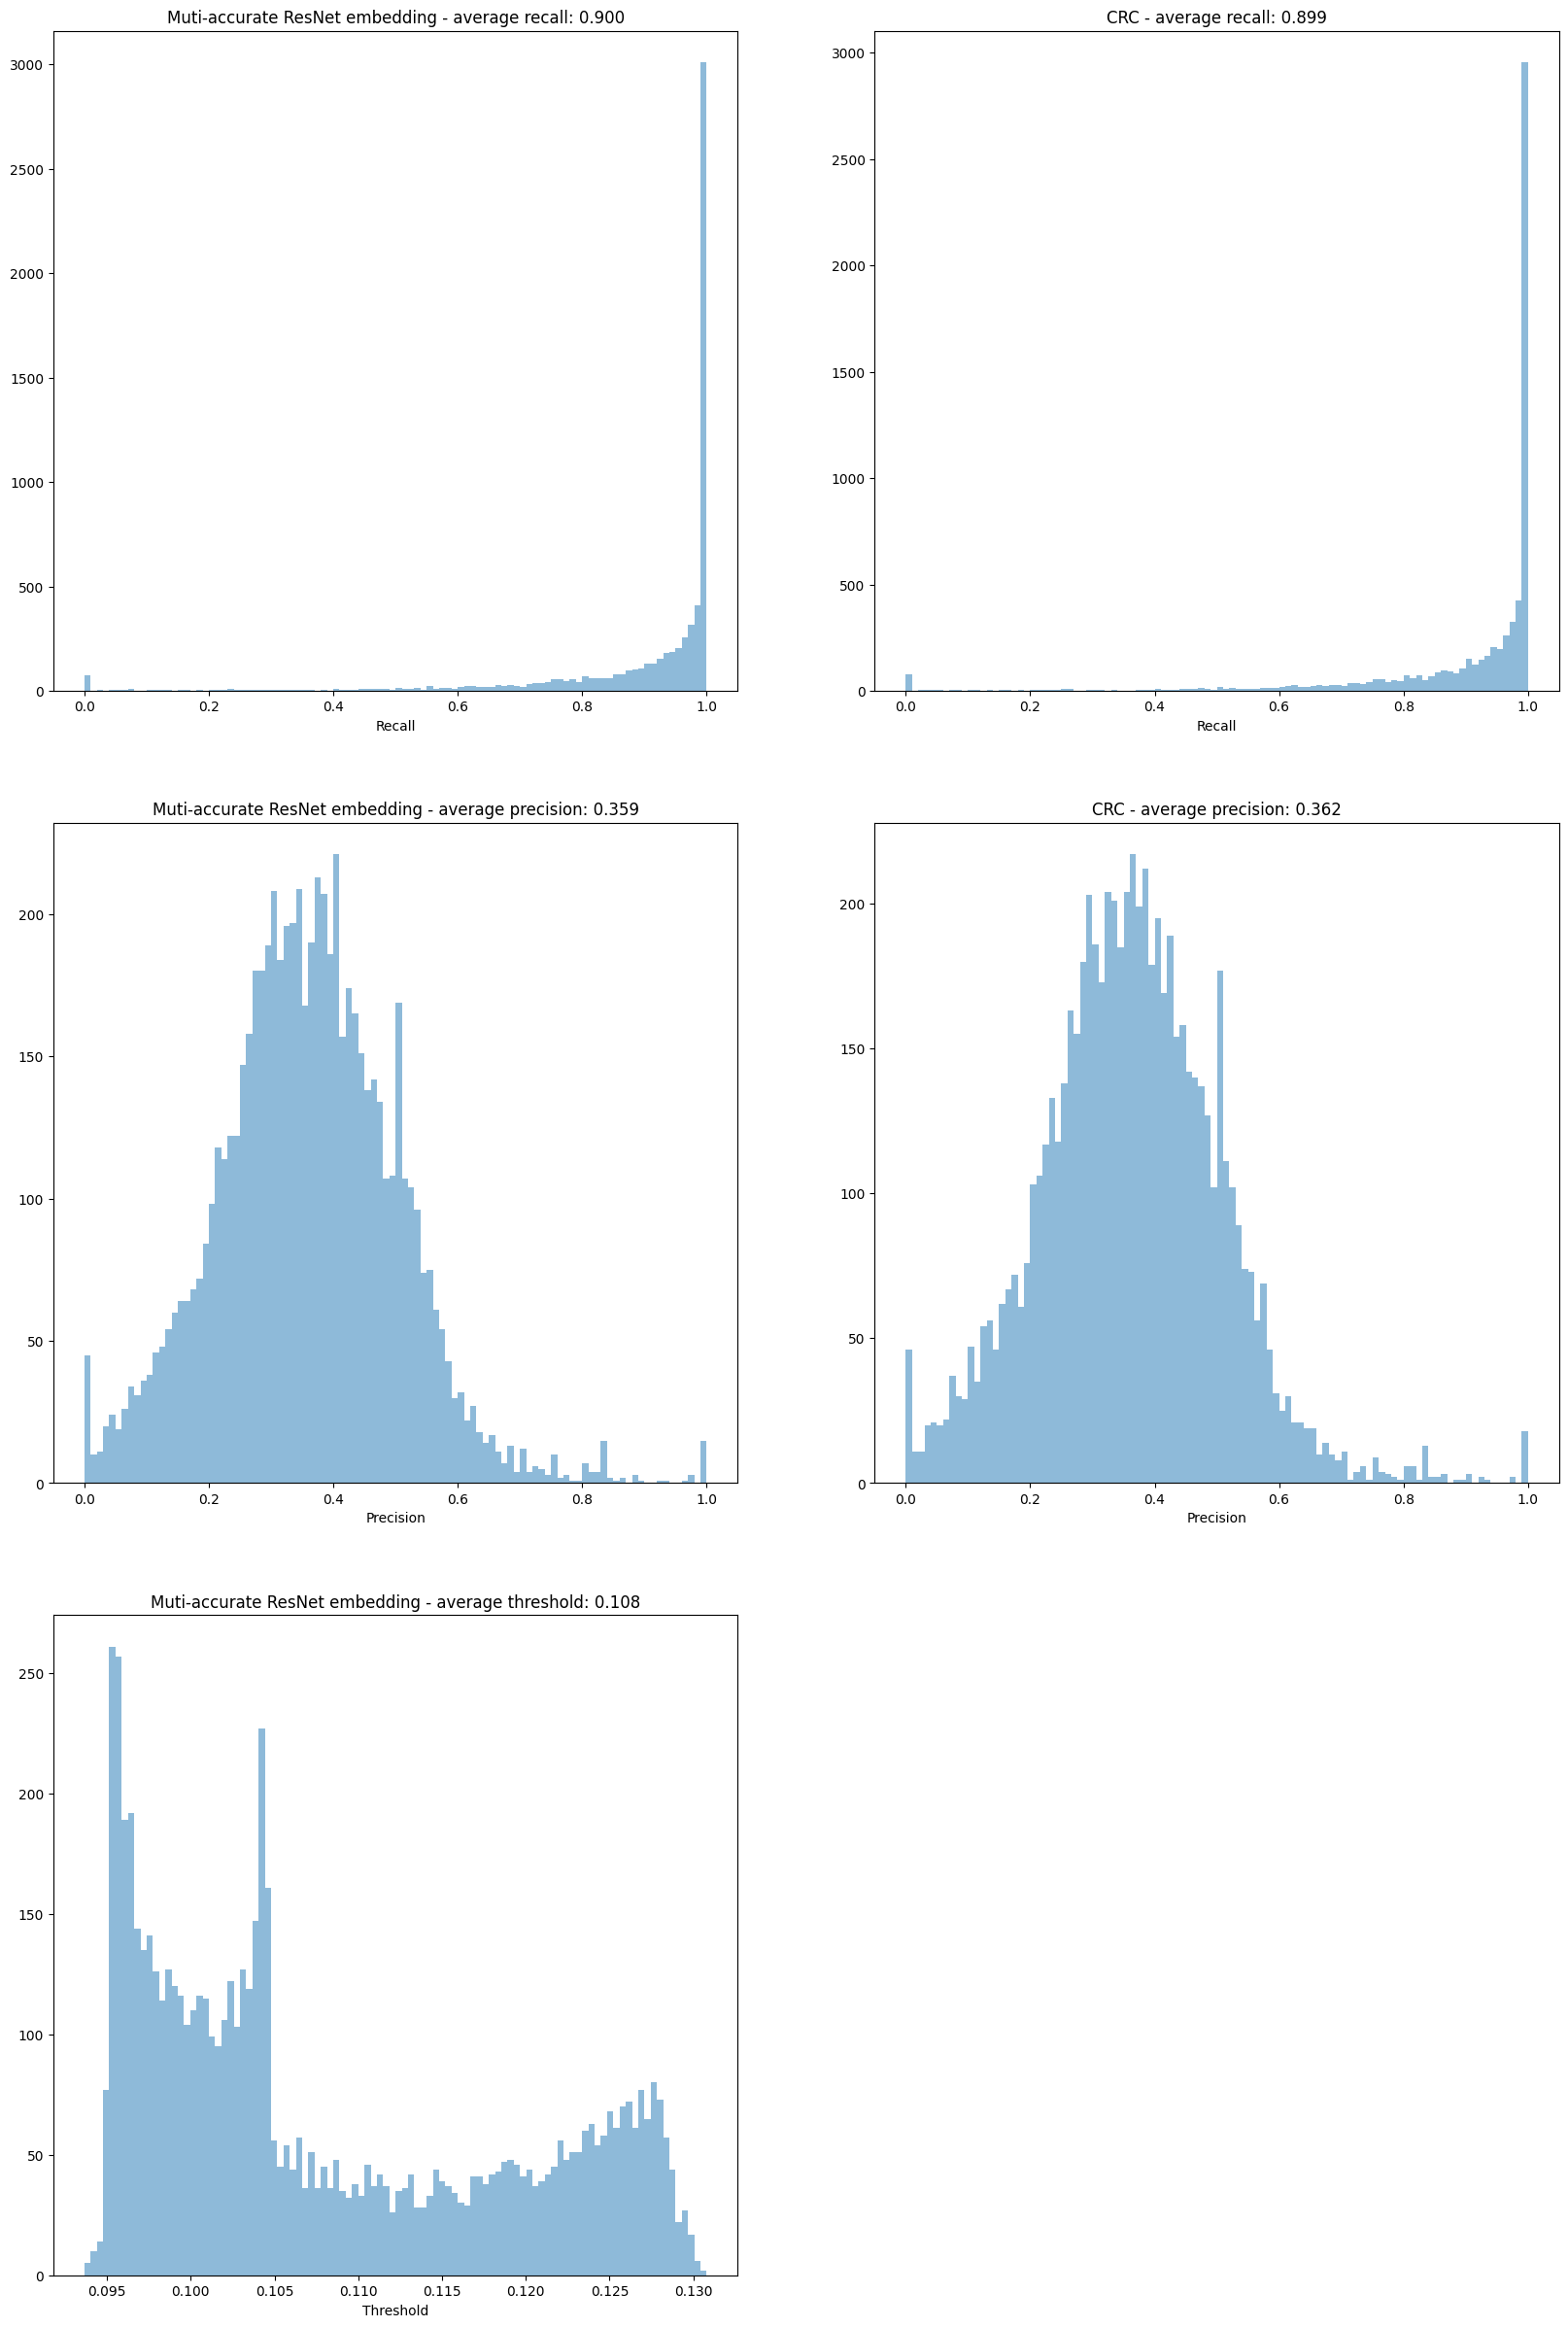

In [33]:
s = 10
nrow = 3
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))



ax[0, 0].hist(recall_resnet, bins=100, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recall_resnet):.3f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recall_test_crc, bins=100, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recall_test_crc):.3f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precision_test_resnet, bins=100, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precision_test_resnet):.3f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precision_test_crc, bins=100, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precision_test_crc):.3f}")
ax[1, 1].set_xlabel("Precision")

ax[2, 0].hist(ths_res[:, 0, 0], bins=100, alpha=.5)
ax[2, 0].set_title(f"Muti-accurate ResNet embedding - average threshold: {np.nanmean(ths_res):.3f}")
ax[2, 0].set_xlabel("Threshold")

ax[2, 1].set_axis_off()

In [39]:
precision_test_crc

array([0.70740741, 0.71220401, 0.76749436, ..., 0.43490305, 0.65946561,
       0.7114094 ])

In [23]:
precision_test_resnet

array([0.70740741, 0.7045045 , 0.76749436, ..., 0.43681319, 0.65946561,
       0.71227856])

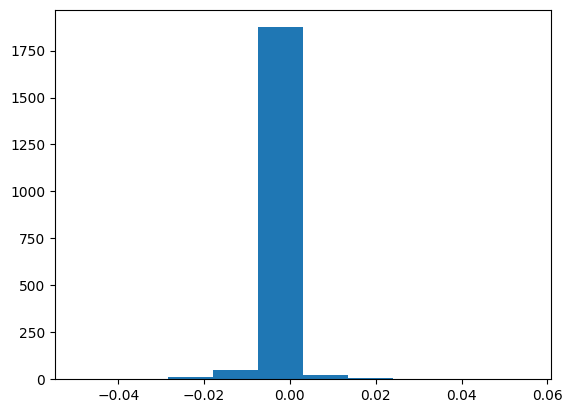

In [24]:
plt.hist(precision_test_resnet - precision_test_crc)
plt.show()

In [25]:
np.nanmean((precision_test_resnet - precision_test_crc))

-0.0012704638943564213

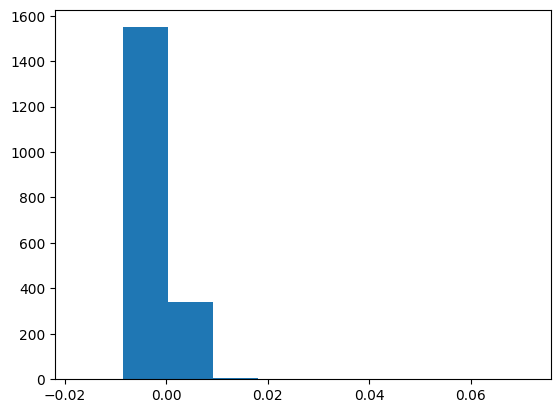

In [26]:
plt.hist(recall_resnet - recall_test_crc)
plt.show()

In [27]:
np.nanmean(precision_test_unet)
t_unet = []
for i in precision_test_unet:
    if i == 0:
        continue
    else:
        t_unet.append(i)

t_resnet = []
for i in precision_test_resnet:
    if i == 0:
        continue
    else:
        t_resnet.append(i)

t_crc = []
for i in precision_test_crc:
    if i == 0:
        continue
    else:
        t_crc.append(i)

np.nanmean(t_unet), np.nanmean(t_resnet), np.nanmean(t_crc)

(0.7384775916068159, 0.7022805341865256, 0.7036104666035967)

In [28]:
np.nanmean(t)

NameError: name 't' is not defined

In [ ]:
len(precision_test_unet)

2300